<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Red-neuronal-artificial-desde-cero-en-Numpy---Problema-del-XOR" data-toc-modified-id="Red-neuronal-artificial-desde-cero-en-Numpy---Problema-del-XOR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Red neuronal artificial desde cero en Numpy - Problema del XOR</a></span><ul class="toc-item"><li><span><a href="#Inicialización-de-los-parámetros" data-toc-modified-id="Inicialización-de-los-parámetros-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Inicialización de los parámetros</a></span></li><li><span><a href="#Feed-Forward" data-toc-modified-id="Feed-Forward-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Feed Forward</a></span></li><li><span><a href="#Función-de-costo" data-toc-modified-id="Función-de-costo-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Función de costo</a></span></li><li><span><a href="#Función-de-backpropagation" data-toc-modified-id="Función-de-backpropagation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Función de backpropagation</a></span></li><li><span><a href="#Una-iteración-de-entrenamiento" data-toc-modified-id="Una-iteración-de-entrenamiento-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Una iteración de entrenamiento</a></span></li><li><span><a href="#Ciclo-de-entrenamiento" data-toc-modified-id="Ciclo-de-entrenamiento-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Ciclo de entrenamiento</a></span></li><li><span><a href="#Encontrar-el-mejor-learning-rate" data-toc-modified-id="Encontrar-el-mejor-learning-rate-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Encontrar el mejor learning rate</a></span></li></ul></li></ul></div>

# Red neuronal artificial desde cero en Numpy - Problema del XOR

Mezcla entre los videos de Siraj Raval y de Andrew Ng
- https://www.youtube.com/watch?v=vcZub77WvFA
- https://www.youtube.com/watch?v=262XJe2I2D0
- https://www.coursera.org/learn/neural-networks-deep-learning/lecture/6dDj7/backpropagation-intuition-optional


Vamos a crear un clasificador binario que podrá aprender la solución a la operación de XOR, utilizando una red neuronal artificial con una capa escondida que sigue la estructura presentada en la siguiente imagen.

<img src="08-01-TradANNDesdeCero.png">

Para ilustrar el procedimiento de back-propagation vamos a utilizar solamente funciones activación sigmoide, y vamos a utilizar numpy para ilustrar las operaciones matemáticas matriciales básicas con numpy.

In [1]:
import numpy as np #operaciones matriciales y con vectores
import matplotlib.pyplot as plt #gráficos
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

Definimos la función sigmoide y su función gradiente basada en si misma.

In [2]:
def sigmoide(x):
    return 1/(1+np.exp(-x))

def sigmoideGrad(x): # x en este caso es el valor de la función sigmoide
    return x*(1-x)

Creamos datos sintéticos (XOR sobre las dos primeras columnas) y especificamos los parámetros de la red neuronal. Incluimos una tercera columna para mostrar que la red resultante aprende a ignorar los atributos que no son importantes.

In [3]:
# Queremos que cada dato registro sea un vector de 3 posiciones. 
# Tenemos aquí 8 registros apilados horizontalmente gracias a la transposición del array incialmente creado
X = np.transpose(np.array([
    [0,0,1],
    [0,1,1],
    [1,0,1],
    [1,1,1],
    [0,0,0],
    [0,1,0],
    [1,0,0],
    [1,1,0]
]))
print("X", X)

y = np.array([
    0, 
    1, 
    1, 
    0,
    0, 
    1, 
    1, 
    0])
print("y", y)


X [[0 0 1 1 0 0 1 1]
 [0 1 0 1 0 1 0 1]
 [1 1 1 1 0 0 0 0]]
y [0 1 1 0 0 1 1 0]


## Inicialización de los parámetros

Inicializamos los pesos de la red aleatoriamente para la capa intermedia (1) y la capa de salida (2). La capa inicial no tiene pesos pues consiste únicamente de los datos de entrada.

La primera capa tiene 4 neuronas y 3 inputs, creamos una matriz de pesos w1 con 4 filas y 3 columnas. Tenemos además un vector b1 con 4 posiciones.

La segunda capa tiene 1 neurona y 4 inputs, creamos una matriz de pesos w2 con 1 fila y 4 columnas. Tenemos además un vector b2 con 1 posición.

In [4]:
def initParams():
    np.random.seed(123456)

    w1 = 2*np.random.random((4, 3))-1
    w2 = 2*np.random.random((1, 4))-1
    b1 = np.zeros((4,1))
    b2 = np.zeros((1,1))
    return(w1, b1, w2, b2)

In [5]:
w1, b1, w2, b2 = initParams()
print("w1: {%s}\nb1: {%s}" % (w1, b1))
print("w2: {%s}\nb2: {%s}" % (w2, b2))

w1: {[[-0.74606033  0.93343568 -0.47904799]
 [ 0.79447305 -0.24650057 -0.32755651]
 [-0.09724706  0.68051017 -0.75379571]
 [ 0.0860524  -0.25397555 -0.10400635]]}
b1: {[[0.]
 [0.]
 [0.]
 [0.]]}
w2: {[[-0.74111864  0.71975741  0.64077673 -0.29589292]]}
b2: {[[0.]]}


Ya tenemos los pesos de toda la red definidos 

## Feed Forward

Cada época, el proceso debe pasar los datos del dataset por las capas, propagando la información hacia adelante a través de las funciones de activación. Veamos como funciona esto en un primer paso.

por convención las "activaciones" de la capa de entrada son los mismos valores de las instancias de entrenamiento. Por eso definimos a0=X

In [6]:
a0 = X # matriz de 3 filas (inputs) * 8 columnas (registros)
a0

array([[0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 0, 0, 0]])

Para pasar la información a través de una capa, vamos a realizar la combinación lineal de las salidas de la capa anterior (producto punto de dos vectores, los **a**'s anteriores y los **w**'s de los pesos de la capa) y a pasar el resultado por una función de activación no lineal (en este caso la sigmoide), teniendo como salida los **a**'s de la cpaa en cuestión.

In [7]:
w1

array([[-0.74606033,  0.93343568, -0.47904799],
       [ 0.79447305, -0.24650057, -0.32755651],
       [-0.09724706,  0.68051017, -0.75379571],
       [ 0.0860524 , -0.25397555, -0.10400635]])

In [10]:
b1

array([[0.],
       [0.],
       [0.],
       [0.]])

In [11]:
z1 = np.dot(w1, a0) + b1 # (4, 3) * (3, 8) --> (4, 8) 4 filas (neuronas capa 1) * 8 columnas (registros = inputs capa 1)
print(z1)
a1 = sigmoide(z1)   # (4, 8) 4 filas (neuronas capa 1) * 8 columnas (registros)
print(a1)

[[-0.47904799  0.45438769 -1.22510832 -0.29167265  0.          0.93343568
  -0.74606033  0.18737534]
 [-0.32755651 -0.57405708  0.46691654  0.22041597  0.         -0.24650057
   0.79447305  0.54797248]
 [-0.75379571 -0.07328554 -0.85104277 -0.1705326   0.          0.68051017
  -0.09724706  0.58326311]
 [-0.10400635 -0.3579819  -0.01795395 -0.2719295   0.         -0.25397555
   0.0860524  -0.16792315]]
[[0.38247695 0.61168194 0.22703873 0.42759443 0.5        0.71777179
  0.32168034 0.54670726]
 [0.41883528 0.3603012  0.61465368 0.55488198 0.5        0.43868502
  0.68879097 0.63366506]
 [0.3199948  0.48168681 0.29921416 0.45746987 0.5        0.66385255
  0.47570738 0.6418179 ]
 [0.47402183 0.41144818 0.49551163 0.43243347 0.5        0.43684522
  0.52149984 0.45811758]]


Se repite el proceso con la siguiente capa, que es la capa de salida.
En **a2** quedan los resultados de las 8 instancias del set de entrenamiento.

In [12]:
z2 = np.dot(w2, a1) + b2 # (1, 4) * (4, 8) --> (1, 8) 1 filas (neuronas capa 2) * 8 columnas (registros)
print(z2)
a2 = sigmoide(z2)  # (1, 8) 1 filas (neuronas capa 2) * 8 columnas (registros)
print(a2)

[[ 0.08278451 -0.00709033  0.31924999  0.24766426  0.16176129  0.07991459
   0.40787322  0.32661841]]
[[0.52068432 0.49822742 0.57914146 0.56160151 0.54035237 0.51996802
  0.60057781 0.58093636]]


Vamos a definimos una función llamada **feedForward**, que nos permita realizar este proceso para cualquier capa (diferente de la de entrada), que recibe la matriz de inputs con todos los registros y retorna el vector con las predicciones correspondientes:

In [12]:
def feedForward(X, w1, b1, w2, b2):
    '''Calcula el valor predicho para todos los registros que se encuentran en X
       -----------
       Argumentos:
       X: matriz con los inputs, con tantas filas como atributos y tantas columnas como registros
       w1: matriz con los pesos de las conexiones entrantes de la 1a capa, 
         con tantas filas como atributos y tantas columnas como registros
       b1: array con los sesgos de las neuronas de la 1a capa
       w2: matriz con los pesos de las conexiones entrantes de la 2a capa, 
         con tantas filas como atributos y tantas columnas como registros
       b2: array con los sesgos de las neuronas de la 2a capa
       -----------
       Retorna:
       a1: matriz con las activaciones de la capa escondida, 
         con tantas filas como neuronas de la capa y tantas columnas como registros
       a2 (y estimado): vector con las predicciones
    '''
    a0 = X # matriz de 3 filas (inputs) * 8 columnas (registros)
    z1 = np.dot(w1, a0) + b1 # (4, 3) * (3, 8) --> (4, 8) 4 filas (neuronas capa 1) * 8 columnas (registros = inputs capa 1)
    a1 = sigmoide(z1)   # (4, 8) 4 filas (neuronas capa 1) * 8 columnas (registros)
    z2 = np.dot(w2, a1) + b2 # (1, 4) * (4, 8) --> (1, 8) 1 filas (neuronas capa 2) * 8 columnas (registros)
    a2 = sigmoide(z2)   # (1, 8) 1 filas (neuronas capa 2) * 8 columnas (registros)
    return (a1, a2)

Podemos entonces evaluar el estado inicial de la red (con sus parámetros inicales), y encontrar los mismos resultados que vimos antes:

In [13]:
a1, a2 = feedForward(X, w1, b1, w2, b2)
print(a2.transpose())

[[0.52068432]
 [0.49822742]
 [0.57914146]
 [0.56160151]
 [0.54035237]
 [0.51996802]
 [0.60057781]
 [0.58093636]]


Vemos que los datos están bastante alejados de la realidad [0, 1, 1, 0, 0, 1, 1, 0].

Ahora necesitamos definir el proceso inverso de back propagation, a través del cuál se pueden ajustar los pesos de la red de manera iterativa, minimizando una función de costo que mide lo lejos de las predicciones con respecto a los valores reales.

## Función de costo

In [14]:
epsilon = 0.00000001 # para evitar problemas de overflow

In [15]:
def costoGlobal(y_real, y_est): 
    '''Calcula el costo global de la predicción con la red actual, comparando la clase real con las probabilidad estimadas
       -----------
       Argumentos:
       y_real: array con las clases reales de los datos
       y_est: array con las probabilidades de salida estimadas por la red
       -----------
       Retorna:
       costo: promedio de los costos de cada predicción individual
    '''
    y_est = np.where(y_est<=0,epsilon,y_est)
    y_est = np.where(y_est>=1,1-epsilon,y_est)
    
    costos = -(np.multiply(y_real, np.log(y_est))) - (np.multiply((1-y_real), np.log(1-y_est))) 
    # (1, 8) 1 filas * 8 columnas (registros)

    return np.abs(np.mean(costos))

In [16]:
costo = costoGlobal(y, a2)
costo

0.7017260765032634

## Función de backpropagation

El proceso de back-propagation comienza por calcular el error, comparando la diferencia entre lo que produce la red (**a2**) y lo que se espera como valor real (**y**).
Vamos a abusar un poco de la nomenclatura para simplificar la escritura de los gradientes.
Por ejemplo, el gradiente de la función de pérdida L con respecto a z2 (agregación de la segunda capa) en vez de notarlo com dL/dz, vamos a notarlo dz. Igual hacemos para referirnos a dL/dw2 como dw2, dL/db2 como db2, etc.

In [17]:
m=X.shape[1] # Número de instancias

In [18]:
m

8

Por definición matemática sabemos que la función de pérdida sigmoide de la última capa tiene la siguiente formula:
$$ 𝐿(𝑦 ̂, 𝑦)=𝐿(𝑎^{[2]}, 𝑦)= −𝑦∗log⁡(𝑎^{[2]}) − (1−𝑦) ∗ log⁡(1−𝑎^{[2]})$$
De ahí, podemos encontrar el gradiente de la pérdida con respecto a las activaciones de la capa 2:
$$\frac{𝜕L}{𝜕𝑎^{[2]}} = \frac{−𝑦}{𝑎^{[2]}}  +   \frac{1−𝑦}{1−𝑎^{[2]}} = \frac{𝑎^{[2]} −𝑦}{𝑎^{[2]}*(1−𝑎^{[2]})}$$

Por otra parte, como $𝑎^{[2]}=sigmoide(z^{[2]})$, podemos decir que 
$$\frac{𝜕𝑎^{[2]}}{𝜕𝑧^{[2]}} = 𝜎^′ (𝑧^{[2]}  )=𝑎^{[2]} * (1−𝑎^{[2]})$$
De ahí,
$$𝜕𝑧^{[2]} = \frac{𝜕L^{[2]}}{𝜕𝑧^{[2]}} = \frac{𝜕L^{[2]}}{𝜕a^{[2]}} * \frac{𝜕a^{[2]}}{𝜕𝑧^{[2]}}
= \frac{(𝑎^{[2]} −𝑦)}{𝑎^{[2]}⋅(1−𝑎^{[2]})} * 𝑎^{[2]} * (1−𝑎^{[2]})
= 𝑎^{[2]} −𝑦
$$

In [19]:
y

array([0, 1, 1, 0, 0, 1, 1, 0])

In [19]:
dz2 = a2-y          # (1, 8) 1 filas * 8 columnas (registros)
dz2

array([[ 0.52068432, -0.50177258, -0.42085854,  0.56160151,  0.54035237,
        -0.48003198, -0.39942219,  0.58093636]])

El gradiente dw2 nos indica que la pendiente de la curva de pérdida con respecto a los pesos de la capa 2, de tal manera que podemos actualizarlos siguiendo la siguiente ecuación.

Partimos de
    $$𝑧^{[2]} = 𝑾^{[𝟐]}* 𝒂^{[𝟏]} + * 𝒃^{[2]} $$
Encontramos el gradiente con respecto a los parámetros:
    $$\frac{𝜕𝑧^{[2]}}{𝜕𝑾^{[𝟐]}} = 𝒂^{[𝟏]}$$
    $$\frac{𝜕𝑧^{[2]}}{𝜕𝒃^{[𝟐]}} = 1$$

De ahí:
    $$𝜕𝑾^{[𝟐]} = \frac{𝜕𝐿}{𝜕𝑾^{[𝟐]}}=\frac{𝜕𝐿}{𝜕𝑧^{[2]}} * \frac{𝜕𝑧^{[2]}}{𝜕𝑾^{[𝟐]}} 
    =𝜕z^{[𝟐]}*𝒂^{[𝟏]}=(𝑎^{[2]} −𝑦)* 𝒂^{[𝟏]}$$
    $$𝜕𝒃^{[𝟐]} = \frac{𝜕𝐿}{𝜕𝒃^{[𝟐]}}=\frac{𝜕𝐿}{𝜕𝑧^{[2]}} * \frac{𝜕𝑧^{[2]}}{𝜕𝒃^{[𝟐]}} 
    =𝜕z^{[𝟐]}*1=(𝑎^{[2]} −𝑦)$$

In [20]:
dw2 = (1/m)*np.dot(dz2, a1.T) # (1, 8) * (8, 4) --> (1, 4) 1 fila (neuronas capa 2), 4 inputs
print(dw2)

[[0.01894371 0.03035325 0.02378262 0.02412405]]


In [21]:
dz2

array([[ 0.52068432, -0.50177258, -0.42085854,  0.56160151,  0.54035237,
        -0.48003198, -0.39942219,  0.58093636]])

In [23]:
np.sum(dz2)

0.4014892687908933

In [24]:
np.sum(dz2)/8

0.05018615859886166

In [19]:
db2 = (1/m)*np.sum(dz2, axis=1, keepdims=True)  # (1,1) 1 fila (neuronas capa 2) 
                                                # El axis=1 permita indicar que queremos las columnas
                                                # el keepdims=True es para que siga siendo una lista de listas
print(db2)

[[0.05018616]]


Continuamos el back propagation y hacemos lo propio con las neuronas de la primera capa.

$$\frac{𝜕𝒛^{[𝟐]}}{𝜕𝒂^{[𝟏]}} = 𝑾^{[𝟐]} $$

$$\frac{𝜕𝐿}{𝜕𝒛^{[𝟏]}} = \frac{𝜕𝐿}{𝜕𝒂^{[𝟐]}}*\frac{𝜕𝒂^{[𝟐]}}{𝜕𝒛^{[𝟐]}}*\frac{𝜕𝒛^{[𝟐]}}{𝜕𝒂^{[𝟏]}}*\frac{𝜕𝒂^{[𝟏]}}{𝜕𝒛^{[𝟏]}}
=(𝑎^{[2]} −𝑦)*𝑾^{[𝟐]}*𝜎^′ (𝑧^{[1]}) $$

In [25]:
dz1 = np.dot(w2.T, dz2) * sigmoideGrad(a1) # (4,1) * (1,8) --> (4, 8) 4 filas (neuronas capa 1), 8 registros

Y teniendo en cuenta la agregación de la primera capa:

$$\frac{𝜕𝑧^{[1]}}{𝜕𝑾^{[1]}} = 𝒂^{[0]} = 𝑿$$
$$\frac{𝜕𝑧^{[1]}}{𝜕𝒃^{[1]}} = 1$$

In [26]:
dw1 = (1/m)*np.dot(dz1, X.T) #(4,8) * (8, 3) --> (4,3) 4 filas (neuronas capa 1), 3 inputs
print(dw1)

[[-0.01115483 -0.00602118 -0.00624334]
 [ 0.00794091  0.00357267  0.004509  ]
 [ 0.00681363  0.0032471   0.00313675]
 [-0.00285442 -0.00157007 -0.00151429]]


In [27]:
db1 = (1/m)*np.sum(dz1, axis=1, keepdims=True) # (4,1) 4 filas (neuronas capa 1)
print(db1)

[[-0.01501239]
 [ 0.01045782]
 [ 0.00809461]
 [-0.0037904 ]]


Ahora que ya se tienen los dw1, dw2, db1 y db2, se podrían actualizar los valores de los parámetros, dado el learning rate definido.

La siguiente función se encarga de encapsular todo el proceso anterior en un solo llamado para facilitar la implementación del entrenamiento.

In [28]:
def backProp(X, y, w1, b1, w2, b2, a1, a2): 
    '''Calcula los deltas de las actualizaciones de los parámetros de las capas 
       -----------
       Argumentos:
       X: matriz con los inputs, con tantas filas como atributos y tantas columnas como registros
       y: array con los valores reales a predecir
       w1: matriz con los pesos de las conexiones entrantes de la 1a capa, 
         con tantas filas como atributos y tantas columnas como registros
       w2: matriz con los pesos de las conexiones entrantes de la 2a capa, 
         con tantas filas como atributos y tantas columnas como registros
       b1: array con los sesgos de las neuronas de la 1a capa
       b2: array con los sesgos de las neuronas de la 2a capa
       a1: matriz con las activaciones de la capa escondida, con tantas filas como neuronas de la capa y tantas columnas como registros
       a2 (y estimado): vector con las predicciones
       -----------
       Retorna:
       dw1: matriz con las actualizaciones que se deben aplicar a los coeficientes de la capa 1 (hidden)
       db1: array con las actualizaciones que se deben aplicar a los sesgos de la capa 1 (hidden)
       dw2: matriz con las actualizaciones que se deben aplicar a los coeficientes de la capa 2 (salida)
       db2: array con las actualizaciones que se deben aplicar a los sesgos de la capa 2 (salida)
    '''
    m=X.shape[1]
    dz2 = a2-y          # (1, 8) 1 filas * 8 columnas (registros)
    dw2 = (1/m)*np.dot(dz2, a1.T) # (1, 8) * (8, 4) --> (1, 4) 1 fila (neuronas capa 2), 4 inputs
    db2 = (1/m)*np.sum(dz2, axis=1, keepdims=True) # (1,1) 1 fila (neuronas capa 2)

    dz1 = np.dot(w2.T, dz2) * sigmoideGrad(a1) # (4,1) * (1,8) --> (4, 8) 4 filas (neuronas capa 1), 8 registros
    dw1 = (1/m)*np.dot(dz1, X.T) #(4,8) * (8, 3) --> (4,3) 4 filas (neuronas capa 1), 3 inputs
    db1 = (1/m)*np.sum(dz1, axis=1, keepdims=True) # (4,1) 4 filas (neuronas capa 1)

    return (dw1, db1, dw2, db2)

In [29]:
dw1, db1, dw2, db2 = backProp(X, y, w1, b1, w2, b2, a1, a2)

## Una iteración de entrenamiento

Vamos ahora a programar el ciclo (época) de back propagation.
- Se calculan los valores intermediarios en la fase forward: a0 (son las entradas X), a1 y a2 (las salidas estimadas y_est)
- Se calcula el error de cada época
- Se encuentran los valores de los gradientes en la fase backward a partir de los resultados anteriores

Para entender mejor lo que pasa durante el entrenamiento de la red, vamos a ver en detalle lo que pasa con la primera época

Lo primero que hacemos es inicializar los pesos y sesgos de la red, así como los parámetros del entrenamiento como la taza de aprendizaje (*learning rate*) y número de épocas.

In [31]:
w1, b1, w2, b2 = initParams()
lr = 1 # learning rate
epocas = 1000 # Iteraciones de backpropagation

Hacemos un paso de feed forward que nos permita obtener la predicción con los pesos y sesgos actuales (iniciales aleatorios) de la red, que vamos a comparar con los valores reales

In [32]:
a1, a2 = feedForward(X, w1, b1, w2, b2)
print("Las predicciones actuales son las activaciones de la neurona de la capa de salida a2:\n", a2)
print("Los valores reales son:\n", y)

Las predicciones actuales son las activaciones de la neurona de la capa de salida a2:
 [[0.52068432 0.49822742 0.57914146 0.56160151 0.54035237 0.51996802
  0.60057781 0.58093636]]
Los valores reales son:
 [0 1 1 0 0 1 1 0]


Vemos que en este momento no hay ninguna relación entre las predicciones y los valores reales.
Vamos entonces a modificar los parámetros de la red con back propagation. Calculamos las actualizaciones y modificamos los valores iniciales.

In [33]:
dw1, db1, dw2, db2 = backProp(X, y, w1, b1, w2, b2, a1, a2)
print("Las actualizaciones son las siguientes:\ndw1:", dw1,"\ndw2:", dw2,"\ndb1:", db1,"\ndb2:", db2)

Las actualizaciones son las siguientes:
dw1: [[-0.01115483 -0.00602118 -0.00624334]
 [ 0.00794091  0.00357267  0.004509  ]
 [ 0.00681363  0.0032471   0.00313675]
 [-0.00285442 -0.00157007 -0.00151429]] 
dw2: [[0.01894371 0.03035325 0.02378262 0.02412405]] 
db1: [[-0.01501239]
 [ 0.01045782]
 [ 0.00809461]
 [-0.0037904 ]] 
db2: [[0.05018616]]


In [40]:
print("Los valores anteriores de los parámetros de la red eran:\nw1:", w1,"\nw2:", w2,"\nb1:", b1,"\nb2:", b2)
w1 = w1-lr*dw1
w2 = w2-lr*dw2
b1 = b1-lr*db1
b2 = b2-lr*db2
print("Los nuevos valores de los parámetros de la red son:\nw1:", w1,"\nw2:", w2,"\nb1:", b1,"\nb2:", b2)

Los valores anteriores de los parámetros de la red eran:
w1: [[-0.74606033  0.93343568 -0.47904799]
 [ 0.79447305 -0.24650057 -0.32755651]
 [-0.09724706  0.68051017 -0.75379571]
 [ 0.0860524  -0.25397555 -0.10400635]] 
w2: [[-0.74111864  0.71975741  0.64077673 -0.29589292]] 
b1: [[0.]
 [0.]
 [0.]
 [0.]] 
b2: [[0.]]
Los nuevos valores de los parámetros de la red son:
w1: [[-0.7349055   0.93945686 -0.47280464]
 [ 0.78653214 -0.25007324 -0.33206551]
 [-0.10406068  0.67726307 -0.75693246]
 [ 0.08890683 -0.25240548 -0.10249206]] 
w2: [[-0.76006235  0.68940416  0.6169941  -0.32001697]] 
b1: [[ 0.01501239]
 [-0.01045782]
 [-0.00809461]
 [ 0.0037904 ]] 
b2: [[-0.05018616]]


Ahora que ya actualizamos los pesos veamos cuáles serían las nuevas predicciones:

In [34]:
print("Las predicciones anteriores eran:\n", a2)
_, a2 = feedForward(X, w1, b1, w2, b2)
print("Las predicciones actuales son:\n", a2)
print("Los valores reales son:\n", y)

Las predicciones anteriores eran:
 [[0.52068432 0.49822742 0.57914146 0.56160151 0.54035237 0.51996802
  0.60057781 0.58093636]]
Las predicciones actuales son:
 [[0.52068432 0.49822742 0.57914146 0.56160151 0.54035237 0.51996802
  0.60057781 0.58093636]]
Los valores reales son:
 [0 1 1 0 0 1 1 0]


Como lo que tenemos en la neurona de salida es una probabilidad, vamos a establecer un umbral de decisión en 50%, y a transformarlas en valores categóricos

In [35]:
np.squeeze(np.where(a2>0.5,1,0))

array([1, 0, 1, 1, 1, 1, 1, 1])

In [36]:
y

array([0, 1, 1, 0, 0, 1, 1, 0])

In [44]:
y_pred = np.squeeze(np.where(a2>0.5,1,0))
print("Las predicciones actuales son:\n", y_pred)
print("Los valores reales son:\n", y)
accuracy = accuracy_score(y_pred, y)
print("El accuracy actual es de :\n", accuracy)

Las predicciones actuales son:
 [0 0 1 1 1 0 1 1]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
El accuracy actual es de :
 0.375


Veamos lo que nos darían una cuantas iteraciones de entrenamiento (época):

In [37]:
a1, a2 = feedForward(X, w1, b1, w2, b2)
dw1, db1, dw2, db2 = backProp(X, y, w1, b1, w2, b2, a1, a2)
w1 = w1-lr*dw1
w2 = w2-lr*dw2
b1 = b1-lr*db1
b2 = b2-lr*db2
print("Las predicciones anteriores eran:\n", a2)
_, a2 = feedForward(X, w1, b1, w2, b2)
print("Las predicciones actuales son:\n", a2)
print("Los valores reales son:\n", y)
y_pred = np.squeeze(np.where(a2>0.5,1,0))
print("Las predicciones actuales son:\n", y_pred)
print("Los valores reales son:\n", y)
accuracy = accuracy_score(y_pred, y)
print("El accuracy actual es de :\n", accuracy)

Las predicciones anteriores eran:
 [[0.52068432 0.49822742 0.57914146 0.56160151 0.54035237 0.51996802
  0.60057781 0.58093636]]
Las predicciones actuales son:
 [[0.49633316 0.47208107 0.55377767 0.53382765 0.51418783 0.49222539
  0.57367961 0.55174205]]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
Las predicciones actuales son:
 [0 0 1 1 1 0 1 1]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
El accuracy actual es de :
 0.375


In [38]:
a1, a2 = feedForward(X, w1, b1, w2, b2)
dw1, db1, dw2, db2 = backProp(X, y, w1, b1, w2, b2, a1, a2)
w1 = w1-lr*dw1
w2 = w2-lr*dw2
b1 = b1-lr*db1
b2 = b2-lr*db2
print("Las predicciones anteriores eran:\n", a2)
_, a2 = feedForward(X, w1, b1, w2, b2)
print("Las predicciones actuales son:\n", a2)
print("Los valores reales son:\n", y)
y_pred = np.squeeze(np.where(a2>0.5,1,0))
print("Las predicciones actuales son:\n", y_pred)
print("Los valores reales son:\n", y)
accuracy = accuracy_score(y_pred, y)
print("El accuracy actual es de :\n", accuracy)

Las predicciones anteriores eran:
 [[0.49633316 0.47208107 0.55377767 0.53382765 0.51418783 0.49222539
  0.57367961 0.55174205]]
Las predicciones actuales son:
 [[0.48466627 0.45978681 0.5411645  0.52012408 0.50171707 0.47925874
  0.56030026 0.53742133]]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
Las predicciones actuales son:
 [0 0 1 1 1 0 1 1]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
El accuracy actual es de :
 0.375


In [47]:
a1, a2 = feedForward(X, w1, b1, w2, b2)
dw1, db1, dw2, db2 = backProp(X, y, w1, b1, w2, b2, a1, a2)
w1 = w1-lr*dw1
w2 = w2-lr*dw2
b1 = b1-lr*db1
b2 = b2-lr*db2
print("Las predicciones anteriores eran:\n", a2)
_, a2 = feedForward(X, w1, b1, w2, b2)
print("Las predicciones actuales son:\n", a2)
print("Los valores reales son:\n", y)
y_pred = np.squeeze(np.where(a2>0.5,1,0))
print("Las predicciones actuales son:\n", y_pred)
print("Los valores reales son:\n", y)
accuracy = accuracy_score(y_pred, y)
print("El accuracy actual es de :\n", accuracy)

Las predicciones anteriores eran:
 [[0.47913414 0.45414591 0.53479923 0.51328983 0.49589635 0.47342138
  0.55359109 0.53040584]]
Las predicciones actuales son:
 [[0.47654773 0.45168378 0.53145902 0.50977198 0.49327171 0.47099409
  0.55012023 0.52692393]]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
Las predicciones actuales son:
 [0 0 1 1 0 0 1 1]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
El accuracy actual es de :
 0.5


In [39]:
a1, a2 = feedForward(X, w1, b1, w2, b2)
dw1, db1, dw2, db2 = backProp(X, y, w1, b1, w2, b2, a1, a2)
w1 = w1-lr*dw1
w2 = w2-lr*dw2
b1 = b1-lr*db1
b2 = b2-lr*db2
print("Las predicciones anteriores eran:\n", a2)
_, a2 = feedForward(X, w1, b1, w2, b2)
print("Las predicciones actuales son:\n", a2)
print("Los valores reales son:\n", y)
y_pred = np.squeeze(np.where(a2>0.5,1,0))
print("Las predicciones actuales son:\n", y_pred)
print("Los valores reales son:\n", y)
accuracy = accuracy_score(y_pred, y)
print("El accuracy actual es de :\n", accuracy)

Las predicciones anteriores eran:
 [[0.48466627 0.45978681 0.5411645  0.52012408 0.50171707 0.47925874
  0.56030026 0.53742133]]
Las predicciones actuales son:
 [[0.47913414 0.45414591 0.53479923 0.51328983 0.49589635 0.47342138
  0.55359109 0.53040584]]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
Las predicciones actuales son:
 [0 0 1 1 0 0 1 1]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
El accuracy actual es de :
 0.5


In [40]:
a1, a2 = feedForward(X, w1, b1, w2, b2)
dw1, db1, dw2, db2 = backProp(X, y, w1, b1, w2, b2, a1, a2)
w1 = w1-lr*dw1
w2 = w2-lr*dw2
b1 = b1-lr*db1
b2 = b2-lr*db2
print("Las predicciones anteriores eran:\n", a2)
_, a2 = feedForward(X, w1, b1, w2, b2)
print("Las predicciones actuales son:\n", a2)
print("Los valores reales son:\n", y)
y_pred = np.squeeze(np.where(a2>0.5,1,0))
print("Las predicciones actuales son:\n", y_pred)
print("Los valores reales son:\n", y)
accuracy = accuracy_score(y_pred, y)
print("El accuracy actual es de :\n", accuracy)

Las predicciones anteriores eran:
 [[0.47913414 0.45414591 0.53479923 0.51328983 0.49589635 0.47342138
  0.55359109 0.53040584]]
Las predicciones actuales son:
 [[0.47654773 0.45168378 0.53145902 0.50977198 0.49327171 0.47099409
  0.55012023 0.52692393]]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
Las predicciones actuales son:
 [0 0 1 1 0 0 1 1]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
El accuracy actual es de :
 0.5


In [41]:
a1, a2 = feedForward(X, w1, b1, w2, b2)
dw1, db1, dw2, db2 = backProp(X, y, w1, b1, w2, b2, a1, a2)
w1 = w1-lr*dw1
w2 = w2-lr*dw2
b1 = b1-lr*db1
b2 = b2-lr*db2
print("Las predicciones anteriores eran:\n", a2)
_, a2 = feedForward(X, w1, b1, w2, b2)
print("Las predicciones actuales son:\n", a2)
print("Los valores reales son:\n", y)
y_pred = np.squeeze(np.where(a2>0.5,1,0))
print("Las predicciones actuales son:\n", y_pred)
print("Los valores reales son:\n", y)
accuracy = accuracy_score(y_pred, y)
print("El accuracy actual es de :\n", accuracy)

Las predicciones anteriores eran:
 [[0.47654773 0.45168378 0.53145902 0.50977198 0.49327171 0.47099409
  0.55012023 0.52692393]]
Las predicciones actuales son:
 [[0.47537419 0.4507378  0.52958194 0.50785311 0.49217844 0.47019185
  0.54821671 0.52514503]]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
Las predicciones actuales son:
 [0 0 1 1 0 0 1 1]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
El accuracy actual es de :
 0.5


## Ciclo de entrenamiento

Ahora que hemos explicado lo que pasa durante una época de entrenamiento, podemos definir una función de entrenamiento que se repita para cada época. Definimos los hiperparámetros del modelo, utilizados para aprender los pesos de las capas (los verdaderos parámetros).

In [42]:
def entrenarRed(epocas, lr, X, y, w1, b1, w2, b2, a1, a2, echo_progression=True):
    '''Se encarga de controlar el ciclo de aprendizaje de los parámetros de la red
       -----------
       Argumentos:
       epocas: número de iteraciones de aprendizaje a calcular 
       lr: (learning rate) tasa de aprendizaje que controla la magnitud de la actualización de los parámetros cada iteración
       X: matriz con los inputs, con tantas filas como atributos y tantas columnas como registros
       y: array con los valores reales a predecir
       w1: matriz con los pesos de las conexiones entrantes de la 1a capa, 
         con tantas filas como atributos y tantas columnas como registros
       w2: matriz con los pesos de las conexiones entrantes de la 2a capa, 
         con tantas filas como atributos y tantas columnas como registros
       b1: array con los sesgos de las neuronas de la 1a capa
       b2: array con los sesgos de las neuronas de la 2a capa
       a1: matriz con las activaciones de la capa escondida, con tantas filas como neuronas de la capa y tantas columnas como registros
       a2 (y estimado): vector con las predicciones
       echo_progression: indica si se desea que se imprima el progreso de la tarea
       -----------
       Retorna:
       costos: array con la evolución del costo de la red despúes de la actualización de cada época
       accuracies: array con la evolución de la exactitud de la red despúes de la actualización de cada época 
       dw1: matriz con las actualizaciones que se deben aplicar a los coeficientes de la capa 1 (hidden)
       db1: array con las actualizaciones que se deben aplicar a los sesgos de la capa 1 (hidden)
       dw2: matriz con las actualizaciones que se deben aplicar a los coeficientes de la capa 2 (salida)
       db2: array con las actualizaciones que se deben aplicar a los sesgos de la capa 2 (salida)
    '''
    costos = []
    accuracies = []
    for i in range(epocas):
        a1, a2 = feedForward(X, w1, b1, w2, b2)
        dw1, db1, dw2, db2 = backProp(X, y, w1, b1, w2, b2, a1, a2)

        # Actualización de los parámetros
        w1 -= lr*dw1
        w2 -= lr*dw2
        b1 -= lr*db1
        b2 -= lr*db2
        
        #Costo y accuracy (usa el feed forward para obtener la predicción y luego calcula el accuracy)
        #Se deben guardar los costos y accuracies en los vectores que se retornarán al final
        _, a2 = feedForward(X, w1, b1, w2, b2)
        y_pred = np.squeeze(np.where(a2>0.5,1,0))
        accuracy = accuracy_score(y_pred, y)        
        accuracies.append(accuracy)
        costo = costoGlobal(y, a2)
        costos.append(costo)
        
        if (echo_progression & (i%10==0)):
            print("Epoca %d, costo = %12.10f, accuracy=%12.10f" % (i, costo, accuracy))
    
    return (costos, accuracies, w1, b1, w2, b2)


Definimos los hyperparámetros del modelo, utilizados para aprender los pesos de las capas (los verdaderos parámetros) y lanzamos el entrenamiento de la red.

In [43]:
lr = 1 # learning rate
epocas = 1000 # Iteraciones de backpropagation

w1, b1, w2, b2 = initParams()
accuracies, costos, w1, b1, w2, b2 = entrenarRed(epocas, lr, X, y, w1, b1, w2, b2, a1, a2)

Epoca 0, costo = 0.6974323856, accuracy=0.3750000000
Epoca 10, costo = 0.6948107134, accuracy=0.5000000000
Epoca 20, costo = 0.6938142023, accuracy=0.5000000000
Epoca 30, costo = 0.6930380901, accuracy=0.6250000000
Epoca 40, costo = 0.6923781649, accuracy=0.6250000000
Epoca 50, costo = 0.6917624945, accuracy=0.5000000000
Epoca 60, costo = 0.6911359616, accuracy=0.5000000000
Epoca 70, costo = 0.6904503749, accuracy=0.5000000000
Epoca 80, costo = 0.6896572964, accuracy=0.5000000000
Epoca 90, costo = 0.6887018733, accuracy=0.5000000000
Epoca 100, costo = 0.6875164854, accuracy=0.5000000000
Epoca 110, costo = 0.6860132125, accuracy=0.5000000000
Epoca 120, costo = 0.6840741001, accuracy=0.5000000000
Epoca 130, costo = 0.6815380328, accuracy=0.5000000000
Epoca 140, costo = 0.6781827277, accuracy=0.5000000000
Epoca 150, costo = 0.6737000475, accuracy=0.6250000000
Epoca 160, costo = 0.6676627698, accuracy=0.6250000000
Epoca 170, costo = 0.6594819722, accuracy=0.7500000000
Epoca 180, costo = 0.

Nuestras predicciones finales son: 

In [44]:
_, a2 = feedForward(X, w1, b1, w2, b2)
print("Las predicciones actuales son:\n", np.squeeze(a2))
print("Los valores reales son:\n", y)
y_pred = np.squeeze(np.where(a2>0.5,1,0))
print("Las predicciones actuales son:\n", y_pred)
print("Los valores reales son:\n", y)
accuracy = accuracy_score(y_pred, y)
print("El accuracy actual es de :\n", accuracy)

Las predicciones actuales son:
 [0.01119753 0.98752439 0.98518618 0.01316119 0.01143432 0.98770127
 0.98535006 0.01401101]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
Las predicciones actuales son:
 [0 1 1 0 0 1 1 0]
Los valores reales son:
 [0 1 1 0 0 1 1 0]
El accuracy actual es de :
 1.0


## Encontrar el mejor learning rate

In [99]:
learningRates = np.arange(0, 2, 0.1)

In [104]:
0.00005
0.00001
0.0005
0.0001
0.005
0.001
0.05
0.01
0.5
0.1


SyntaxError: invalid syntax (1259671576.py, line 1)

In [85]:
learningRates

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [93]:
lr_list = learningRates.tolist()
lr_list.append(100.0)
lr_list

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2000000000000002,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.8,
 1.9000000000000001,
 10.0,
 100.0]

In [94]:
learningRates = np.array(lr_list)

In [95]:
learningRates

array([  0. ,   0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,
         0.9,   1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,   1.7,
         1.8,   1.9,  10. , 100. ])

In [100]:
costosFinales = []
accuraciesFinales = []

for lr in learningRates:
    w1, b1, w2, b2 = initParams()
    costos, accuracies, w1, b1, w2, b2 = entrenarRed(epocas, lr, X, y, w1, b1, w2, b2, a1, a2, False)
    costosFinales.append(costos[epocas-1])
    accuraciesFinales.append(accuracies[epocas-1])
    print("LR: ", lr, ", costo: ", costos[epocas-1], ", accuracy: ", accuracies[epocas-1])

LR:  0.0 , costo:  0.7017260765032634 , accuracy:  0.375
LR:  0.1 , costo:  0.6875540686783325 , accuracy:  0.5
LR:  0.2 , costo:  0.6121044003321473 , accuracy:  0.875
LR:  0.30000000000000004 , costo:  0.2051989319349055 , accuracy:  1.0
LR:  0.4 , costo:  0.07794847342592806 , accuracy:  1.0
LR:  0.5 , costo:  0.044652706177736375 , accuracy:  1.0
LR:  0.6000000000000001 , costo:  0.030641708186291243 , accuracy:  1.0
LR:  0.7000000000000001 , costo:  0.0231172367819532 , accuracy:  1.0
LR:  0.8 , costo:  0.018473020651848044 , accuracy:  1.0
LR:  0.9 , costo:  0.015339725265469669 , accuracy:  1.0
LR:  1.0 , costo:  0.013091445417201038 , accuracy:  1.0
LR:  1.1 , costo:  0.011403744144878127 , accuracy:  1.0
LR:  1.2000000000000002 , costo:  0.010092455060701758 , accuracy:  1.0
LR:  1.3 , costo:  0.009045599260370987 , accuracy:  1.0
LR:  1.4000000000000001 , costo:  0.008191325440908438 , accuracy:  1.0
LR:  1.5 , costo:  0.007481490018496194 , accuracy:  1.0
LR:  1.6 , costo:  

In [101]:
costosFinales = np.array(costosFinales)

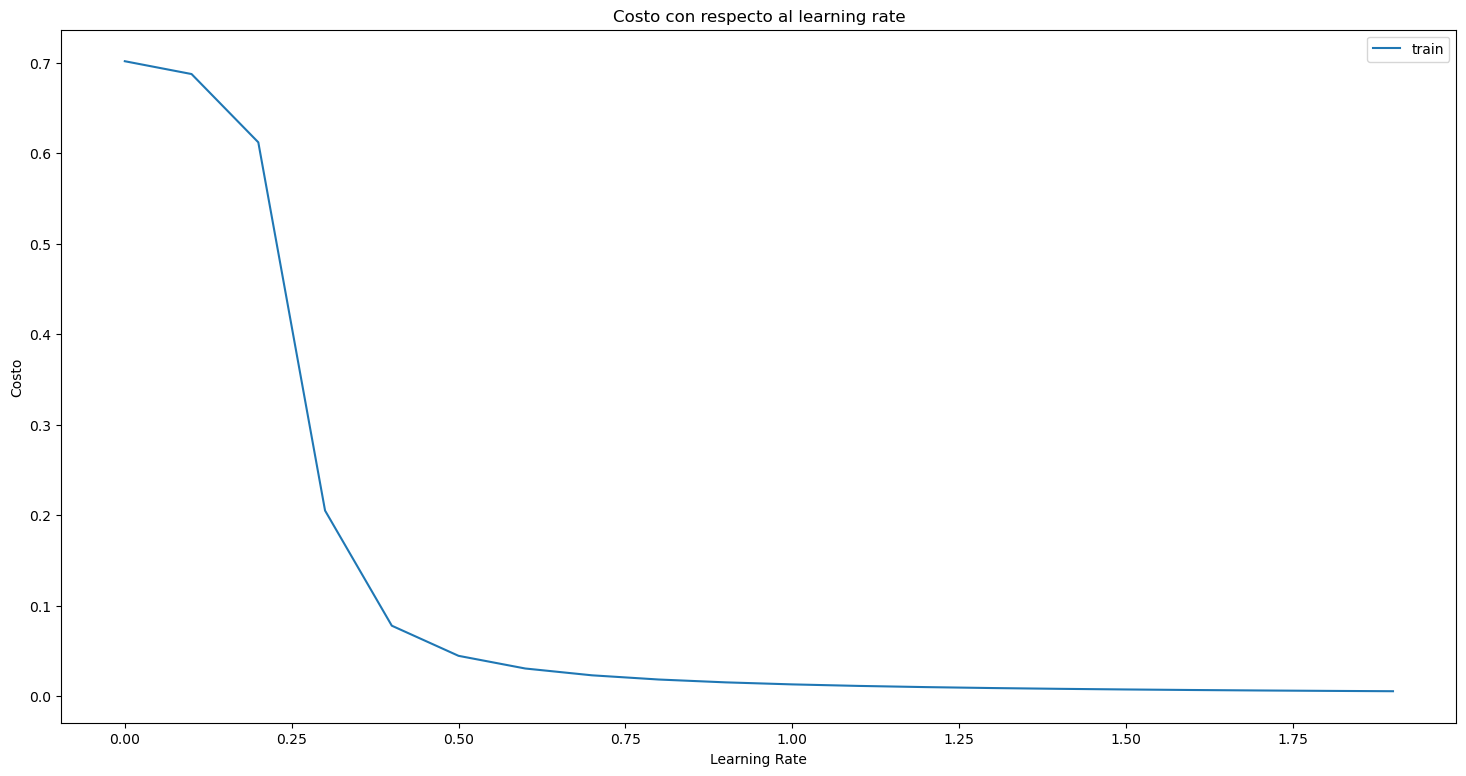

In [102]:
plt.figure(figsize=(18,9))
ax = plt.gca()
plt.plot(learningRates, costosFinales)
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('Learning Rate')
plt.ylabel('Costo')
plt.title('Costo con respecto al learning rate')
plt.legend(['train', 'test'])
plt.show()